**Chapter 11 – Deep Learning**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

In [35]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Vanishing/Exploding Gradients Problem

[-5, 5, -0.2, 1.2]

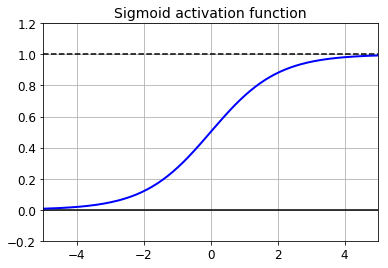

In [36]:
def logit(z):
    return 1/(1+np.exp(-z))

z=np.linspace(-5,5,200)
plt.plot([-5,5],[0,0],'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot(z,logit(z),'b-',linewidth=2)
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

## Xavier and He Initialization

Note:  The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* it does not support `tensorflow.contrib.framework.arg_scope()` (introduced later in chapter 11).
* it does not support regularizer params (introduced later in chapter 11).

In [37]:
import tensorflow as tf
tf.reset_default_graph()
n_inputs=28*28
n_hidden1=300
X=tf.placeholder(tf.float32,shape=(None,n_inputs),name="X")

he_init=tf.variance_scaling_initializer()
hidden1=tf.layers.dense(X,n_hidden1,activation=tf.nn.relu,kernel_initializer=he_init,name="hidden1")


## Nonsaturating Activation Functions非饱和激活函数
### 1、Leaky ReLU

Saving figure leaky_relu_plot


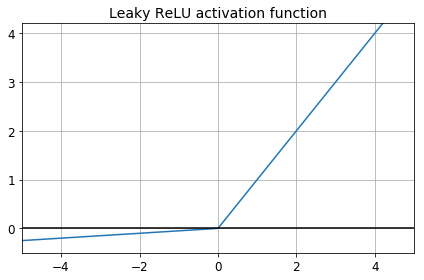

In [38]:
import numpy as np
def leaky_relu(z,alpha=0.01):
    return np.maximum(alpha*z,z)

z=np.linspace(-5,5,200)
plt.plot(z,leaky_relu(z,0.05))
plt.plot([-5,5],[0,0],'k-')
plt.grid(True)
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

## Implementing Leaky ReLU in TensorFlow:
Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

## 构建阶段

In [39]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [40]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)       #注意这里的maximum函数是tensorflow库里的

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

    
with tf.name_scope("loss"):
    xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)#根据logits计算交叉熵，返回每个实例（0到9）的交叉熵的一维张量
    loss=tf.reduce_mean(xentropy,name="loss")

learning_rate=0.01
with tf.name_scope("train"):
    optimizer=tf.train.GradientDescentOptimizer(learning_rate)
    train_op=optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct=tf.nn.in_top_k(logits,y,1)#检查最高的logit值对应类别是否正确，返回一维张量，bool类型
    accuracy=tf.reduce_mean(tf.cast(correct,tf.float32))# 转化为浮点型，求平均

init=tf.global_variables_initializer()
saver=tf.train.Saver()


In [41]:
loss_summary=tf.summary.scalar("Loss",loss)#创建一个节点来求loss
file_writer=tf.summary.FileWriter(logdir,tf.get_default_graph())

### 执行阶段

In [42]:
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.mnist.load_data()
X_train=X_train.astype(np.float32).reshape(-1,28*28)/255.0
X_test=X_test.astype(np.float32).reshape(-1,28*28)/255.0
y_atrain=y_train.astype(np.int32)
y_test=y_test.astype(np.int32)
X_valid,X_train=X_train[:5000],X_train[5000:]
y_valid,y_train=y_train[:5000],y_train[5000:]
X_train.shape

(55000, 784)

In [53]:
def shuffle_batch(X,y,batch_size):
    rnd_idx=np.random.permutation(len(X))
    n_batches=len(X)//batch_size#向下取整
    for batch_idx in np.array_split(rnd_idx,n_batches):
        X_batch,y_batch=X[batch_idx],y[batch_idx]
        yield X_batch,y_batch       

In [48]:
n_epochs=10
batch_size=50
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch,y_batch in shuffle_batch(X_train,y_train,batch_size):  
            summary_str = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
            file_writer.add_summary(summary_str, epoch)
            #sess.run(train_op,feed_dict={X:X_batch,y:y_batch})
        if epoch%3==0:
            acc_batch=accuracy.eval(feed_dict={X:X_batch,y:y_batch})
            acc_valid=accuracy.eval(feed_dict={X:X_batch,y:y_batch})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
            

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.06 Validation accuracy: 0.06
3 Batch accuracy: 0.08 Validation accuracy: 0.08
6 Batch accuracy: 0.12 Validation accuracy: 0.12
9 Batch accuracy: 0.04 Validation accuracy: 0.04


In [46]:
file_writer.close()

### ELU加速线性单元

[-5, 5, -2.2, 3.2]

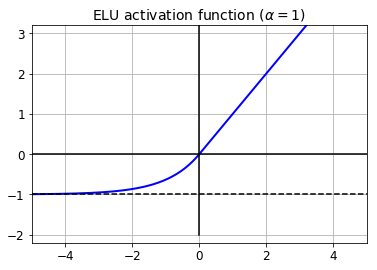

In [43]:
def elu(z,alpha=1):
    return np.where(z<0,np.exp(z)*alpha-1,z)

z=np.linspace(-5,5,200)
plt.plot(z,elu(z),'b-',linewidth=2)
plt.plot([-5,5],[0,0],'k-')
plt.plot([-5,5],[-1,-1],'k--')
plt.plot([0,0],[-2,5],'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [12]:
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1=tf.layers.dense(X,300,activation=tf.nn.elu,name="hidden1")

##  SELU
*这个激活功能是由（https://arxiv.org/pdf/1706.02515.pdf）中提出的。
在训练期间，一个神经网络专门由使用SELU激活函数和LeCun初始化的一堆密集层将自我标准化：每层的输出将倾向于在训练期间保持相同的均值和方差，
这解决了消失/爆炸的梯度问题。因此，这种激活功能对于这样的神经网络来说非常显着地优于其他激活功能，
遗憾的是，SELU激活函数的自标准化特性很容易被破坏：你不能使用ℓ1或ℓ2 正则化， regular dropout, max-norm,跳过连接或其他非连续拓扑
（因此递归神经网络不会自我标准化）。但是，在实践中，它对顺序CNN非常有效。如果打破自我规范化，SELU不一定会胜过其他激活函数。*

In [44]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
print(alpha_0_1)
print(scale_0_1)

1.67326324235
1.05070098736


-1.03885500718
-0.9932620530009145


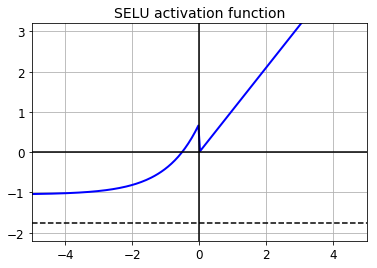

In [57]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):#官方文档参数写反了
    return scale * elu(z, alpha)
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
print(selu(-5))
print(elu(-5))

默认情况下，SELU超参数（`scale`和`alpha`）的调整方式使得每个神经元的平均输出保持接近0，标准偏差保持接近1（假设输入标准化为均值0 和标准差1）。 使用此激活功能，即使是1,000层深度神经网络也可以在所有层上保留大致平均值0和标准偏差1，从而避免爆炸/消失梯度问题：

In [46]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean 0.35, std deviation 0.73
Layer 100: mean 0.31, std deviation 0.21
Layer 200: mean 0.29, std deviation 0.20
Layer 300: mean 0.29, std deviation 0.21
Layer 400: mean 0.30, std deviation 0.21
Layer 500: mean 0.29, std deviation 0.21
Layer 600: mean 0.34, std deviation 0.21
Layer 700: mean 0.33, std deviation 0.21
Layer 800: mean 0.26, std deviation 0.21
Layer 900: mean 0.31, std deviation 0.20


其实就是ELU乘了个lambda，关键在于这个lambda是大于1的。以前relu，prelu，elu这些激活函数，都是在负半轴坡度平缓，这样在activation的方差过大的时候可以让它减小，防止了梯度爆炸，但是正半轴坡度简单的设成了1。而selu的正半轴大于1，在方差过小的的时候可以让它增大，同时防止了梯度消失。这样激活函数就有一个不动点，网络深了以后每一层的输出都是均值为0方差为1。

Let's create a neural net for MNIST using the SELU activation function:

In [51]:
def selu(z, scale=alpha_0_1, alpha=scale_0_1):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 20
batch_size = 50

## Do not forget to scale the inputs to mean 0 and standard deviation 1

In [54]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.94 Validation accuracy: 0.9314
5 Batch accuracy: 0.98 Validation accuracy: 0.961
10 Batch accuracy: 1.0 Validation accuracy: 0.9674
15 Batch accuracy: 0.96 Validation accuracy: 0.969


# Batch Normalization
Note:现在我们使用 `tensorflow.contrib.layers.batch_norm()`，不用 `tf.layers.batch_normalization()`，后者已经删除.
更流行的是使用 `tf.layers.batch_normalization()`,因为contrib模块中的任何内容都可能会改变或被删除，恕不另行通知。 我们现在不使用batch_norm()函数作为fully_connected()函数的正则化参数，而是使用batch_normalization()，并明确地创建一个不同的层。 参数有些不同，特别是：
* `decay`变成 `momentum`,
* `is_training`编程 `training`,
* `updates_collections` is removed: batch normalization所需的更新操作被添加到`UPDATE_OPS`集合中，你需要在训练期间明确地运行这些操作  (see the execution phase below),
* 我们不需要指定scale = True，因为这是默认值

还要注意，为了在每个隐藏层激活函数之前运行批量标准化，我们要在批量规范层之后，手动应用 RELU 激活函数。
注意：由于tf.layers.dense()函数与本书中使用的tf.contrib.layers.arg_scope()不兼容，我们现在使用 python 的functools.partial()函数。 它可以很容易地创建一个my_dense_layer()函数，只需调用tf.layers.dense()，并自动设置所需的参数（除非在调用my_dense_layer()时覆盖它们）。 如您所见，代码保持非常相似。

In [ ]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

为了避免一遍又一遍重复相同的参数，我们可以使用 Python 的partial()函数：

In [59]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')#给Batch norm加一个placeholder
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

##  using the ELU activation function and Batch Normalization ，build a neural net for MNIST

In [64]:
reset_graph()
batch_norm_momentum=0.9
X=tf.placeholder(tf.float32,shape=(None,n_inputs),name="X")
y=tf.placeholder(tf.int32,shape=(None),name="y")
training=tf.placeholder_with_default(False,shape=(),name="training")#存的是bool类型，

with tf.name_scope("dnn"):
    he_init=tf.variance_scaling_initializer()
    my_batch_norm_layer=partial(tf.layers.batch_normalization,training=training,momentum=batch_norm_momentum)
    my_dense_layer=partial(tf.layers.dense,kernel_initializer=he_init)
    
    hidden1=my_dense_layer(X,n_hidden1,name="hidden1")
    bn1=tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2=my_dense_layer(bn1,n_hidden2,name="hidden2")
    bn2=tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn=my_dense_layer(bn2,n_outputs,name="outputs")
    logits=my_batch_norm_layer(logits_before_bn)
    
with tf.name_scope("loss"):
    xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss=tf.reduce_mean(xentropy,name="Loss")
    
with tf.name_scope("train"):
    optimizer=tf.train.GradientDescentOptimizer(learning_rate)
    training_op=optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct=tf.nn.in_top_k(logits,y,1)
    accuracy=tf.reduce_mean(tf.cast(correct,tf.float32))
    
init=tf.global_variables_initializer()
saver=tf.train.Saver()

In [65]:
#注意：由于我们使用的是 tf.layers.batch_normalization() 而不是 tf.contrib.layers.batch_norm()（如本书所述），
# 所以我们需要明确运行批量规范化所需的额外更新操作（sess.run([ training_op，extra_update_ops], ...)。
n_epochs = 20
batch_size = 200
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8952
1 Validation accuracy: 0.9202
2 Validation accuracy: 0.9318
3 Validation accuracy: 0.9422
4 Validation accuracy: 0.9468
5 Validation accuracy: 0.954
6 Validation accuracy: 0.9568
7 Validation accuracy: 0.96
8 Validation accuracy: 0.962
9 Validation accuracy: 0.9638
10 Validation accuracy: 0.9662
11 Validation accuracy: 0.9682
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9726
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9742


   这对 MNIST 来说不是一个很好的准确性。 当然，如果你训练的时间越长，准确性就越好，但是由于这样一个浅的网络，批量归一化和 ELU 不太可能产生非常积极的影响：它们大部分都是为了更深的网络而发光。请注意，您还可以训练操作取决于更新操作：
```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

This way, you would just have to evaluate the `training_op` during training, TensorFlow would automatically run the update operations as well:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

## Gradient Clipping梯度裁剪
_Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier (except we added a few more layers to demonstrate reusing pretrained models, see below):_

In [66]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [67]:
#Now we apply gradient clipping. For this, we need to get the gradients, use the clip_by_value() function to clip them, then apply them:
learning_rate=0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [68]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init=tf.global_variables_initializer()
saver=tf.train.Saver()
n_epochs=10
batch_size=200
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.7936
2 Validation accuracy: 0.8796
3 Validation accuracy: 0.9056
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9214
6 Validation accuracy: 0.9294
7 Validation accuracy: 0.9358
8 Validation accuracy: 0.9376
9 Validation accuracy: 0.9412


## Reusing a TensorFlow Model

In [69]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt") 

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9458
1 Validation accuracy: 0.947
2 Validation accuracy: 0.9476
3 Validation accuracy: 0.9532
4 Validation accuracy: 0.9564
5 Validation accuracy: 0.9566
6 Validation accuracy: 0.9576
7 Validation accuracy: 0.9586
8 Validation accuracy: 0.9626
9 Validation accuracy: 0.961


但是，一般情况下，您只需要重新使用原始模型的一部分（就像我们将要讨论的那样）。如果您使用import_meta_graph（），它将加载整个图形，但您可以简单地忽略您不需要的部分。 在这个例子中，我们在预训练的第3层顶部添加了一个新的第4个隐藏层（忽略旧的第4个隐藏层）。 我们还构建了一个新的输出层，这个新输出的损失，以及一个新的优化器来最小化它。 我们还需要另一个保存程序来保存整个图形（包含整个旧图形和新操作），以及初始化操作以初始化所有新变量：

In [70]:
reset_graph()
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")
#Next you need to get a handle on all the operations you will need for training. 
#If you don't know the graph's structure, you can list all the operations:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [71]:
n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

#执行
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")#加载旧模型

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")#保存新模型

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8972
1 Validation accuracy: 0.9172
2 Validation accuracy: 0.928
3 Validation accuracy: 0.9342
4 Validation accuracy: 0.939
5 Validation accuracy: 0.94
6 Validation accuracy: 0.946
7 Validation accuracy: 0.9508
8 Validation accuracy: 0.9512
9 Validation accuracy: 0.9526


如果你可以访问构建原始图形的Python代码，则可以重用所需的部分并删除其余部分：（上面的情况是只有原模型文件）

In [72]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
#创建一个restore_saver来恢复预训练模型（为其提供要恢复的变量列表，否则它会抱怨图形不匹配）    
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                            # not shown in the book
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        # not shown
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     # not shown
        print(epoch, "Validation accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.892
1 Validation accuracy: 0.9174
2 Validation accuracy: 0.9292
3 Validation accuracy: 0.9366
4 Validation accuracy: 0.9394
5 Validation accuracy: 0.943
6 Validation accuracy: 0.9436
7 Validation accuracy: 0.947
8 Validation accuracy: 0.9484
9 Validation accuracy: 0.951


##  Freezing the Lower Layers

In [73]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,#在训练期间冻结较低层，最简单的解决方案是给优化器列出要训练的变量，不包括来自较低层的变量：
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)
    

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") 
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.883
1 Validation accuracy: 0.9122
2 Validation accuracy: 0.9232
3 Validation accuracy: 0.9294
4 Validation accuracy: 0.9324
5 Validation accuracy: 0.934
6 Validation accuracy: 0.9352
7 Validation accuracy: 0.9356
8 Validation accuracy: 0.9362
9 Validation accuracy: 0.9366


# Faster Optimizers

Momentum optimization：

optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)
                                       
Nesterov Accelerated Gradient：

optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)
                                       
AdaGrad：

optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

RMSProp：

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)
                                      
Adam Optimization：

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Learning Rate Scheduling

In [74]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9626
1 Validation accuracy: 0.9722
2 Validation accuracy: 0.9746
3 Validation accuracy: 0.9806
4 Validation accuracy: 0.9814


## Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [75]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

#将正则项添加到损失函数中
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")#Returns the `Tensor` with the given `name`.
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")
scale = 0.001 # l1 regularization hyperparameter
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 10
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988
6 Validation accuracy: 0.9016
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9058
9 Validation accuracy: 0.906


或者，我们可以将正则化函数传递给tf.layers.dense（）函数，该函数将使用它来创建计算正则化损失的运算，并将这些运算添加到正则化损失的集合中

In [76]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

scale=0.001
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))        #添加l1正则函数

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

In [77]:
#将正则loss添加到loss
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 10
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8274
1 Validation accuracy: 0.8766
2 Validation accuracy: 0.8952
3 Validation accuracy: 0.9016
4 Validation accuracy: 0.908
5 Validation accuracy: 0.9096
6 Validation accuracy: 0.9124
7 Validation accuracy: 0.9154
8 Validation accuracy: 0.9178
9 Validation accuracy: 0.919


## Dropout

In [ ]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

training = tf.placeholder_with_default(False, shape=(), name='training')#训练时True，测试时False

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 10
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

## Max norm

In [ ]:
reset_graph()
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [ ]:
#clip_norm >= l2_norm
#           t = t
#    else
#          t = t*clip_norm/l2norm(t)
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs=10
batch_size=50
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})   # not shown
        print(epoch, "Validation accuracy:", acc_valid)                 # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")               # not shown

##  另一种方法
定义一个max_norm_regularizer()函数，用这个函数来得到一个最大范数调节器（与你想要的阈值）。
就是调用这个函数会返回一个函数。 当你创建一个隐藏层时，你可以将这个正则化器传递给kernel_regularizer参数

In [79]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)            
        tf.add_to_collection(collection, clip_weights)                   #把变量放入一个集合
        return None # there is no regularization loss term
    return max_norm

In [80]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

max_norm_reg = max_norm_regularizer(threshold=1.0)                           # 得到一个最大范数调节器

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs=10
batch_size=50

clip_all_weights = tf.get_collection("max_norm")       #把裁剪的权重取出来，从一个集合中取出全部变量，是一个列表

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

0 Validation accuracy: 0.9556
1 Validation accuracy: 0.9704
2 Validation accuracy: 0.9672
3 Validation accuracy: 0.9734
4 Validation accuracy: 0.977
5 Validation accuracy: 0.9752
6 Validation accuracy: 0.9804
7 Validation accuracy: 0.9802
8 Validation accuracy: 0.9836
9 Validation accuracy: 0.982
